In [1]:
import math
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from scipy.stats import chi2, norm, pearsonr
import matplotlib.ticker as ticker

In [1]:
%reload_ext pycodestyle_magic

In [134]:
%pycodestyle_off

# № 1 

Параметрические доверительные интервалы с помощью bootstrap методами normal, percentile, pivotal.

2 столбца данных считаются выборкой двухмерных нормальных векторов (так как их плотности схожи с нормальными).

Интервалы строятся для коэффициента корреляции Пирсона.

In [39]:
data = pd.read_csv('lsat.csv', sep=';')

In [40]:
data.head()

,LSAT,GPA
1,622,3.23
2,542,2.83
3,579,3.24
4,653,3.12
5,606,3.09


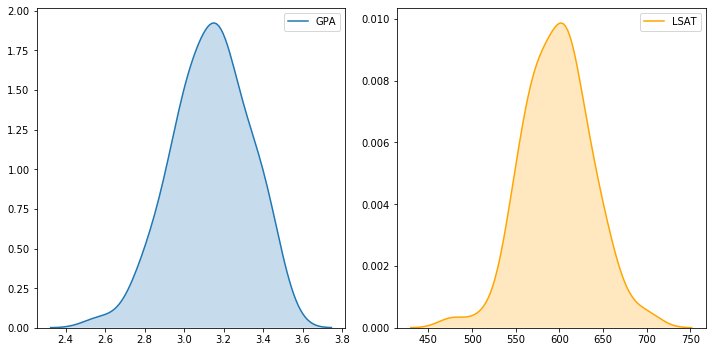

In [43]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.kdeplot(data['GPA'], shade='True')
plt.subplot(1, 2, 2)
sns.kdeplot(data['LSAT'], shade='True', color='orange')
plt.tight_layout()

In [77]:
mean_vector = np.mean([data['LSAT'], data['GPA']], axis=1)
covariance_matrix = np.cov(data['LSAT'], data['GPA'])
pearson_coef = pearsonr(data['LSAT'], data['GPA'])[0]

In [135]:
def pearson_normal_bootstrap(data1: list, data2: list, alpha: float,
                             num_of_samples: int):
    if len(data1) != len(data2):
        raise Exception('Sizes of data1 and data2 must be equal')
    else:
        data_size = len(data1)
    mean_vector = np.mean([data1, data2], axis=1)
    covariance_matrix = np.cov(data1, data2)
    pearson_coef = pearsonr(data1, data2)[0]
    bootstrap_samples = list()
    for _ in range(num_of_samples):
        new_sample = np.random.multivariate_normal(mean_vector,
                                                   covariance_matrix,
                                                   size=data_size)
        bootstrap_samples.append(new_sample.T)
    var_list = [(pearsonr(sample[0], sample[1])[0] - pearson_coef)**2
                for sample in bootstrap_samples]
    variance = np.mean(var_list)
    standard_deviation = np.sqrt(variance)
    lower_bound = pearson_coef - norm.ppf(1 - alpha/2)*standard_deviation
    lower_bound = round(lower_bound, 3)
    upper_bound = pearson_coef + norm.ppf(1 - alpha/2)*standard_deviation
    upper_bound = round(upper_bound, 3)
    return (lower_bound, upper_bound)


def pearson_percentile_bootstrap(data1: list, data2: list, alpha: float,
                                 num_of_samples: int):
    if len(data1) != len(data2):
        raise Exception('Sizes of data1 and data2 must be equal')
    else:
        data_size = len(data1)
    mean_vector = np.mean([data1, data2], axis=1)
    covariance_matrix = np.cov(data1, data2)
    bootstrap_samples = list()
    for _ in range(num_of_samples):
        new_sample = np.random.multivariate_normal(mean_vector,
                                                   covariance_matrix,
                                                   size=data_size)
        bootstrap_samples.append(new_sample.T)
    bootstrap_estimations = [pearsonr(sample[0], sample[1])[0]
                             for sample in bootstrap_samples]
    bootstrap_estimations.sort()
    lower_quantile = math.floor((alpha/2) * num_of_samples)
    upper_quantile = math.floor((1-alpha/2) * num_of_samples)
    lower_bound = bootstrap_estimations[lower_quantile]
    lower_bound = round(lower_bound, 3)
    upper_bound = bootstrap_estimations[upper_quantile]
    upper_bound = round(upper_bound, 3)
    return (lower_bound, upper_bound)


def pearson_pivotal_bootstrap(data1: list, data2: list, alpha: float,
                              num_of_samples: int):
    if len(data1) != len(data2):
        raise Exception('Sizes of data1 and data2 must be equal')
    else:
        data_size = len(data1)
    mean_vector = np.mean([data1, data2], axis=1)
    covariance_matrix = np.cov(data1, data2)
    pearson_coef = pearsonr(data1, data2)[0]
    bootstrap_samples = list()
    for _ in range(num_of_samples):
        new_sample = np.random.multivariate_normal(mean_vector,
                                                   covariance_matrix,
                                                   size=data_size)
        bootstrap_samples.append(new_sample.T)
    bootstrap_estimations = [pearsonr(sample[0], sample[1])[0]
                             for sample in bootstrap_samples]
    bootstrap_estimations.sort()
    lower_quantile = math.floor((1-alpha/2) * num_of_samples)
    upper_quantile = math.floor((alpha/2) * num_of_samples)
    lower_bound = 2*pearson_coef - bootstrap_estimations[lower_quantile]
    lower_bound = round(lower_bound, 3)
    upper_bound = 2*pearson_coef - bootstrap_estimations[upper_quantile]
    upper_bound = round(upper_bound, 3)
    return (lower_bound, upper_bound)

In [137]:
alpha = 0.05
num_of_samples = 1000
normal = pearson_normal_bootstrap(data['LSAT'], data['GPA'],
                                  alpha, num_of_samples)
percentile = pearson_percentile_bootstrap(data['LSAT'], data['GPA'],
                                          alpha, num_of_samples)
pivotal = pearson_pivotal_bootstrap(data['LSAT'], data['GPA'],
                                    alpha, num_of_samples)
print('normal interval:', normal)
print('percentile interval:', percentile)
print('pivotal interval:', pivotal)

normal interval: (0.67, 0.85)
percentile interval: (0.658, 0.838)
pivotal interval: (0.675, 0.87)


# № 2

Доверительный эллипс для параметров p1 и p2 мультиномиального распределения.

ОМП для мультиномиального распределения: $$\hat{p_i} = \frac{n_i}{n}$$ Асимптотическая матрица ковариации: $$\Sigma(\hat{p})= 
\begin{pmatrix}
\hat{p_1}(1-\hat{p_1}) & -\hat{p_1}\hat{p_2} \\
-\hat{p_1}\hat{p_2} & \hat{p_2}(1-\hat{p_2}) 
\end{pmatrix}$$

In [147]:
input_table = pd.read_csv('test.csv')
input_table

,1,2,3,4,5,6,7,8,9
0,3,10,16,13,16,19,18,13,10


In [148]:
input_array = np.array(input_table.iloc[0])

In [407]:
def covariance_matrix(estimations_ls):
    p1, p2 = estimations_ls
    matrix = np.array([[p1*(1-p1), -p1*p2],
                       [-p1*p2, p2*(1-p2)]])
    return matrix

In [408]:
bad_guys = sum(input_array[:5])
middle_guys = sum(input_array[5:7])
good_guys = sum(input_array[7:])
gen_count = sum(input_array)
estimations = np.array([good_guys, middle_guys]) / gen_count
cov_matrix = covariance_matrix(estimations)
inv_matrix = np.linalg.inv(cov_matrix)

In [409]:
p1 = np.linspace(0, 1, 1000)
p2 = np.linspace(0, 1, 1000)
P1, P2 = np.meshgrid(p1, p2)
P1 = estimations[0] - P1
P2 = estimations[1] - P2
F = inv_matrix[0][0]*P1**2 + inv_matrix[1][1]*P2**2 + 2*inv_matrix[0][1]*P1*P2 

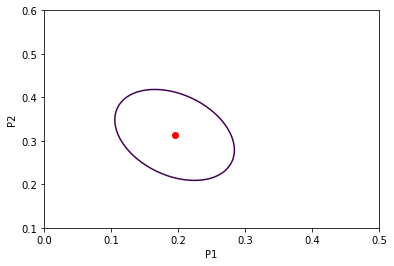

In [413]:
alpha = 0.05
quantile = chi2.ppf(q=1-alpha, df=2) / gen_count
plt.contour(P1+estimations[0], P2+estimations[1], F, [quantile])
plt.xlabel('P1')
plt.ylabel('P2')
plt.xlim([0, 0.5])
plt.ylim([0.1, 0.6])
plt.scatter(estimations[0], estimations[1], color='red')
plt.show()

# № 3

В файле Inspection Data.txt приведены данные об инспекциях на некоторых объектах. 
Указан номер инспекции, после которой впервые были обнаружены нарушения. Построить доверительный интервал для вероятности нарушения, считая, что инспекции независимы и обнаруживают нарушение с вероятностью p.

In [3]:
input_str = str()
with open('Inspection Data.txt', 'r') as file:
    for row in file:
        input_str += row
input_list = input_str.split()
input_list = np.array(input_list).astype(int)

In [17]:
def method_of_moments_interval(data: list, alpha: float):
    data = np.array(data)
    mean = np.mean(data)
    data_size = len(data)
    prob_estimation = 1 / mean
    variance_est = np.mean(data**2) - mean**2
    asympoptic_var = variance_est / mean**4
    quantile_multiplier = np.sqrt(asympoptic_var / data_size)
    lower_bound = prob_estimation - norm.ppf(1 - alpha/2)*quantile_multiplier
    upper_bound = prob_estimation - norm.ppf(alpha/2)*quantile_multiplier
    return (lower_bound, upper_bound)


def geomprob_pivotal_bootstrap(data: list, alpha: float,
                               num_of_samples: int):
    data_size = len(data)
    prob_estimation = 1 / np.mean(data)
    bootstrap_samples = list()
    for _ in range(num_of_samples):
        new_sample = np.random.geometric(p=prob_estimation,
                                         size=data_size)
        bootstrap_samples.append(new_sample)
    bootstrap_estimations = [1 / np.mean(sample) for sample
                             in bootstrap_samples]
    bootstrap_estimations.sort()
    lower_quantile = math.floor((1-alpha/2) * num_of_samples)
    upper_quantile = math.floor((alpha/2) * num_of_samples)
    lower_bound = 2*prob_estimation - bootstrap_estimations[lower_quantile]
    lower_bound = round(lower_bound, 3)
    upper_bound = 2*prob_estimation - bootstrap_estimations[upper_quantile]
    upper_bound = round(upper_bound, 3)
    return (lower_bound, upper_bound)

In [16]:
lower_bound, upper_bound = method_of_moments_interval(input_list, 0.05)
print(f'Method of moments confidence interval: ({lower_bound:.3f}, {upper_bound:.3f})')

Method of moments confidence interval: (0.084, 0.191)


In [41]:
lower_bound, upper_bound = geomprob_pivotal_bootstrap(input_list, 0.05, 100)
print(f'Pivotal bootstrap confidence interval: ({lower_bound:.3f}, {upper_bound:.3f})')

Pivotal bootstrap confidence interval: (0.092, 0.181)
